In [1]:
!pip install scikit-image scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 15.0 MB/s eta 0:00:00


In [2]:
import skfuzzy as fuzz
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage.measure import label, regionprops
from sklearn.cluster import KMeans

In [5]:
import os
import zipfile

zip_file_path = '/content/archive.zip'
extraction_path = '/content'

os.makedirs(extraction_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"'{zip_file_path}' extracted to '{extraction_path}'")

'/content/archive.zip' extracted to '/content'


In [87]:
BASE_DIR = "/content/GrTh"

IMG_DIR = os.path.join(BASE_DIR, "Original")
MASK_DIR = os.path.join(BASE_DIR, "Ground Truth")

ORIG = IMG_DIR
GT = MASK_DIR

CELL_TYPES = ["Eosinophil", "Lymphocyte", "Monocyte", "Neutrophil"]

In [112]:
def preprocess(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    img = cv2.GaussianBlur(img, (5,5), 0)

    return img

In [113]:
def locate_cell(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]

    _, binary = cv2.threshold(b_channel, 0, 255,
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((5,5)))

    comp = label(binary)
    props = regionprops(comp)

    if not props:
        return None

    h, w = binary.shape
    center = np.array([h//2, w//2])

    best = min(props, key=lambda r: np.linalg.norm(np.array(r.centroid)-center))

    return (comp == best.label).astype(np.uint8)

In [114]:
def clean_mask(mask):
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

In [127]:
def apply_kmeans(img, region_mask):
    if np.sum(region_mask) == 0:
        return None, None

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    data = lab[region_mask==1].reshape(-1,3)

    if data.shape[0] < 2:
        return None, None

    model = KMeans(n_clusters=2, random_state=10)
    cluster_labels = model.fit_predict(data)

    centers = model.cluster_centers_

    idx = np.argmin(centers[:,0])

    full_map = np.zeros(region_mask.shape)
    full_map[region_mask==1] = cluster_labels

    nucleus = (full_map == idx).astype(np.uint8)
    nucleus = clean_mask(nucleus)

    cytoplasm = region_mask - nucleus

    return nucleus, cytoplasm

In [116]:
def apply_fcm(img, region_mask):
    if np.sum(region_mask) == 0:
        return None, None, None

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    data = lab[region_mask==1].reshape(-1,3).T

    centers, membership, *_ = fuzz.cluster.cmeans(
        data, c=2, m=2, error=0.005, maxiter=400
    )

    labels = np.argmax(membership, axis=0)

    idx = np.argmin(centers[:,0])

    full_map = np.zeros(region_mask.shape)
    full_map[region_mask==1] = labels

    nucleus = (full_map == idx).astype(np.uint8)
    nucleus = clean_mask(nucleus)

    cytoplasm = region_mask - nucleus

    return nucleus, cytoplasm, membership

In [131]:
def boundary(mask):
    if mask is None:
        return np.zeros((224,224), dtype=np.uint8)
    return cv2.morphologyEx(mask.astype(np.uint8),
                            cv2.MORPH_GRADIENT,
                            np.ones((3,3)))

def boundary_f1(pred, gt):
    pb = boundary(pred)
    gb = boundary(gt)

    inter = np.logical_and(pb, gb).sum()

    prec = inter / (pb.sum()+1e-8)
    rec  = inter / (gb.sum()+1e-8)

    return 2*prec*rec/(prec+rec+1e-8)

In [118]:
def load_sample(cell):
    imgs = glob(os.path.join(ORIG,cell,"**","*.*"), recursive=True)
    masks = glob(os.path.join(GT,cell,"**","*.*"), recursive=True)

    if len(imgs)==0 or len(masks)==0:
        return None, None

    img = cv2.cvtColor(cv2.imread(imgs[0]), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(masks[0],0)

    return cv2.resize(img,(224,224)), cv2.resize(mask,(224,224))


Eosinophil → KM: 0.191, FCM: 0.190


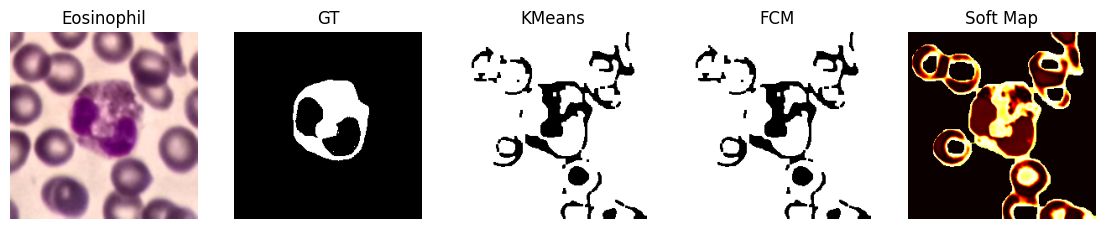

Lymphocyte → KM: 0.157, FCM: 0.148


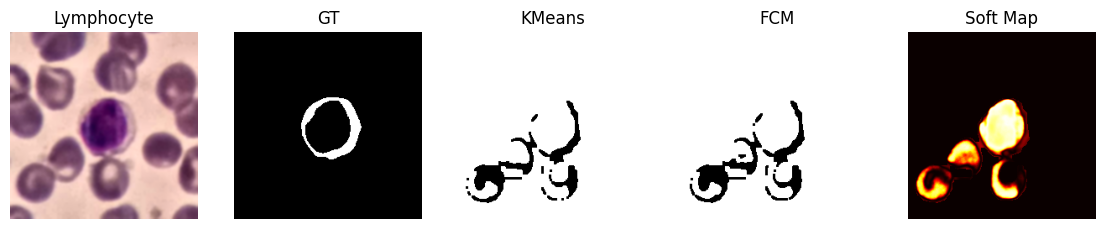

Monocyte → KM: 0.221, FCM: 0.243


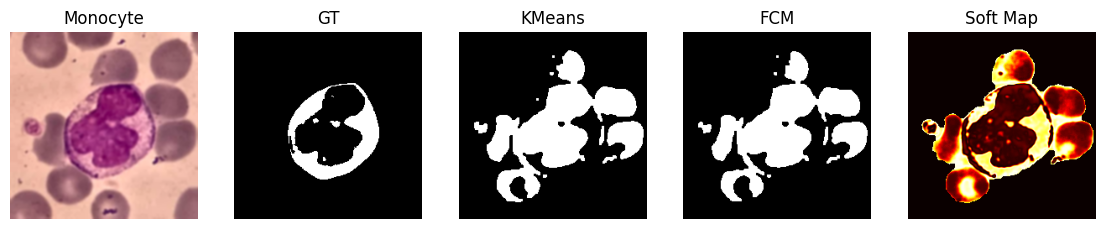

Neutrophil → KM: 0.193, FCM: 0.191


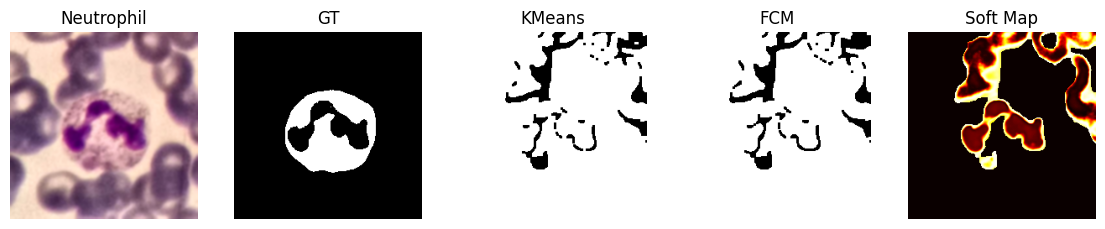

In [128]:
for cell in CELL_TYPES:
    img, gt = load_sample(cell)

    if img is None:
        continue

    img = preprocess(img)

    region = locate_cell(img)
    if region is None:
        continue

    gt_nucleus = (gt > 128).astype(np.uint8)

    km_nuc, _ = apply_kmeans(img, region)
    fcm_nuc, _, membership = apply_fcm(img, region)

    km_score = boundary_f1(km_nuc, gt_nucleus)
    fcm_score = boundary_f1(fcm_nuc, gt_nucleus)

    print(f"{cell} → KM: {km_score:.3f}, FCM: {fcm_score:.3f}")

    idx = np.argmin(membership.mean(axis=1))
    soft = np.zeros(region.shape)
    soft[region==1] = membership[idx]

    plt.figure(figsize=(14,4))
    plt.subplot(1,5,1); plt.imshow(img); plt.title(cell); plt.axis('off')
    plt.subplot(1,5,2); plt.imshow(gt_nucleus,cmap='gray'); plt.title("GT"); plt.axis('off')
    plt.subplot(1,5,3); plt.imshow(km_nuc,cmap='gray'); plt.title("KMeans"); plt.axis('off')
    plt.subplot(1,5,4); plt.imshow(fcm_nuc,cmap='gray'); plt.title("FCM"); plt.axis('off')
    plt.subplot(1,5,5); plt.imshow(soft,cmap='hot'); plt.title("Soft Map"); plt.axis('off')
    plt.show()

In [129]:
def load_dataset(cell):
    imgs = sorted(glob(os.path.join(IMG_DIR, cell, "**", "*.*"), recursive=True))
    masks = sorted(glob(os.path.join(MASK_DIR, cell, "**", "*.*"), recursive=True))

    imgs = [p for p in imgs if p.lower().endswith(('.png','.jpg','.jpeg'))]
    masks = [p for p in masks if p.lower().endswith(('.png','.jpg','.jpeg'))]

    return list(zip(imgs, masks))

In [134]:
summary = []

for cell in CELL_TYPES:

    pairs = load_dataset(cell)

    km_list = []
    fcm_list = []

    print(f"\nProcessing {cell}: {len(pairs)} samples")

    for img_p, mask_p in pairs:

        img = cv2.cvtColor(cv2.imread(img_p), cv2.COLOR_BGR2RGB)
        gt  = cv2.imread(mask_p, 0)

        img = preprocess(cv2.resize(img,(224,224)))
        gt  = cv2.resize(gt,(224,224))

        region = locate_cell(img)
        if region is None:
            continue

        gt_nucleus = (gt > 128).astype(np.uint8)

        km_nuc,_ = apply_kmeans(img, region)
        fcm_nuc,_,_ = apply_fcm(img, region)

        if km_nuc is None or fcm_nuc is None:
          continue

        if np.sum(km_nuc) == 0 or np.sum(fcm_nuc) == 0:
          continue

        km_list.append(boundary_f1(km_nuc, gt_nucleus))
        fcm_list.append(boundary_f1(fcm_nuc, gt_nucleus))

    summary.append([
        cell,
        np.mean(km_list),
        np.mean(fcm_list)
    ])



Processing Eosinophil: 201 samples

Processing Lymphocyte: 242 samples

Processing Monocyte: 242 samples

Processing Neutrophil: 242 samples


In [135]:
df = pd.DataFrame(summary, columns=["Cell Type","KMeans F1","FCM F1"])

print("\nFINAL RESULT")
print(df)


FINAL RESULT
    Cell Type  KMeans F1    FCM F1
0  Eosinophil   0.260097  0.264089
1  Lymphocyte   0.279852  0.278919
2    Monocyte   0.229588  0.230874
3  Neutrophil   0.277833  0.281857
